### Imports

In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf
from fitting import BiexpFitter

sys.path.append("../python-analysis")
import torch_clustering as clorch
import cluster_ae_builds as builds
from conv1d_deep_cluster import Conv1dDeepClusterer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** interactive figures (jupyter notebook)
- **widget ->** interactive figures (jupyter lab)

In [2]:
# %matplotlib qt 
%matplotlib notebook
# %matplotlib widget

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/spontaneous/"
tiff_path = os.path.join(base_path, "")

In [4]:
stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)
mean_stack_proj = np.mean(stacks, axis=(0, 1))
n_trials, n_frames, n_rows, n_cols = stacks.shape 

# hz = 58.2487
hz = 208.5
dt = 1 / hz
recs_xaxis = np.arange(n_frames) * dt

# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94
pix_w = rec_width / n_cols
pix_h = rec_height / n_rows

print("stacks shape:", stacks.shape)

stacks shape: (1, 8000, 60, 256)


### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


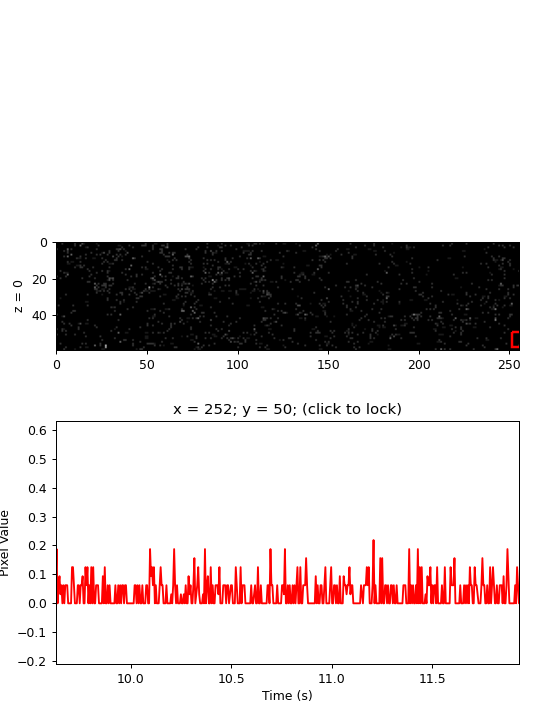

Recording shape: (8000, 60, 256)


In [5]:
stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
#     roi_sz=(8, 6),
    roi_sz=(16, 8),
#     vmin=0,
#     auto_roi_scale=True,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
# stacks_plot.fig.show()
stacks_plot.fig.tight_layout()

### Grid ROI placement
Take `grid_w` by `grid_h` beams from the scan field.

In [6]:
grid_w = 8
grid_h = 6
grid_cols = n_cols // grid_w
grid_rows = n_rows // grid_h

grid_recs, grid_idxs, all_qis, accepted_qis = [[] for _ in range(4)]
for x0 in range(0, n_cols, grid_w):
    for y0 in range(0, n_rows, grid_h):
        beams = np.mean(stacks[:, :, y0:y0 + grid_h, x0:x0 + grid_w], axis=(2, 3))
        grid_recs.append(beams)
        grid_idxs.append([x0, y0])

grid_recs = np.stack(grid_recs, axis=1)
avg_grid_recs = np.mean(grid_recs, axis=0)
grid_idxs = np.stack(grid_idxs, axis=0)
grid_locs = grid_idxs * np.array([pix_w, pix_h])
print("number of grid ROIs accepted:", grid_recs.shape[1])
print("grid_cols = %i, grid_rows = %i" % (grid_cols, grid_rows))


# normalize to noise and remove offset
grid_recs /= np.var(grid_recs[:, :, -150:], axis=2).reshape(*grid_recs.shape[:2], 1)
grid_recs -= np.mean(grid_recs[:, :, -150:], axis=2).reshape(*grid_recs.shape[:2], 1)
avg_grid_recs /= np.var(avg_grid_recs[:, -150:], axis=1).reshape(avg_grid_recs.shape[0], 1)
avg_grid_recs -= np.mean(avg_grid_recs[:, -150:], axis=1).reshape(avg_grid_recs.shape[0], 1)

number of grid ROIs accepted: 320
grid_cols = 32, grid_rows = 10


<IPython.core.display.Javascript object>


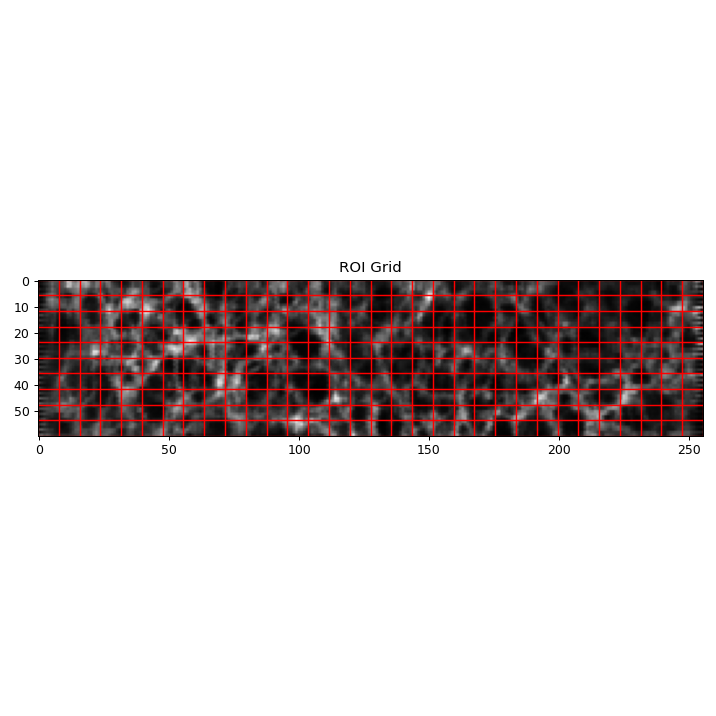

In [7]:
half_w = grid_w / 2
half_h = grid_h / 2
grid_fig, grid_ax = plt.subplots(1, figsize=(8, 8))

grid_ax.imshow(mean_stack_proj, cmap="gray")
grid_ax.set_title("ROI Grid")

for (x, y) in grid_idxs:
    grid_ax.add_patch(
        Rectangle(
            (x - .5, y - .5),  # grid offset
            grid_w, 
            grid_h, 
            fill=False,
            color="red",
            linewidth=1,
            linestyle="-"
        )
    )

grid_fig.tight_layout()

In [8]:
tau1 = 2 # rise [ms]
# tau2 = 30  # decay [ms]
tau2 = 40  # decay [ms]
quantum_pts = 100

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

template = biexp_quantum / biexp_quantum.max()
template = np.concatenate([np.zeros(quantum_pts), template])
template = np.flip(template)

### Grid ROI post-processing

In [9]:
grid_butt = butter_lowpass_filter(grid_recs, 20, hz)
grid_svgl = signal.savgol_filter(grid_recs, 5, polyorder=2, axis=-1)
grid_butt_svgl = signal.savgol_filter(grid_butt, 15, polyorder=3, axis=-1)
grid_roll = rolling_average(grid_recs, n=31)
grid_conv = map_axis(lambda a: np.convolve(a, template, mode="same"), grid_recs)

<IPython.core.display.Javascript object>


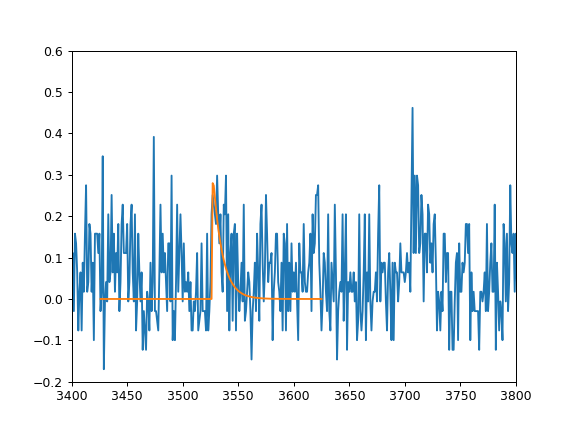

(-0.2, 0.6)

In [10]:
template_fig, template_ax = plt.subplots(1)
# template_ax.plot(grid_svgl[0][95] / grid_svgl[0][95].max())
template_ax.plot(grid_recs[0][95] / grid_recs[0][95].max())
template_ax.plot(np.arange(len(template)) + 3426, np.flip(template) * 0.28)
template_ax.set_xlim(3400, 3800)
template_ax.set_ylim(-0.2, 0.6)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

<IPython.core.display.Javascript object>


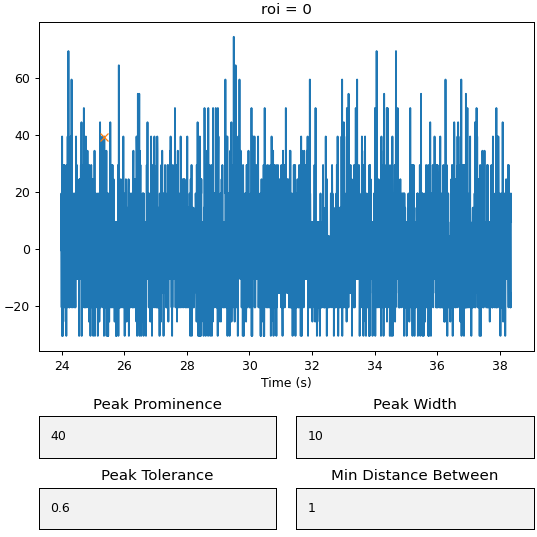

11.011243


In [11]:
start_idx = 5000
peak_explorer = PeakExplorer(
    recs_xaxis[start_idx:], 
    grid_recs[0][:, start_idx:],
#     grid_svgl[0][:, start_idx:],
#     grid_roll[0][:, start_idx:],
#     grid_butt[0][:, start_idx:],
#     grid_butt_svgl[0][:, start_idx:],
#     signal.detrend(grid_butt_svgl[0][:, start_idx:]),
#     grid_conv[0][:, start_idx:],
    prominence=40,
    width=10,
    tolerance=.6,
    distance=1,
    auto_y_scale=False,
)

print(np.sqrt(np.var(grid_svgl[0][:, -2000:])))

### Mean Squared Error (MSE)
![observed vs prediction](assets/mse_points_difference.png)
![MSE formula](assets/mse_formula.gif)

### Cross Correlation:
![cross correlating sines](assets/cross_correlation_sines.gif)

Signals are "slid" along one another, and their similarity is measured at each position. This example in particular is *auto-correlation*, thus the peak correlation is `1.0`. We want to compare between ROIs with different signals, so ours will actually be *cross-correlation*. 
![cross vs auto](assets/cross_vs_auto_correlation.png)


### MSE and cross-correlation between all ROIs
For each ROI calculate the MSE/cross-correlation with each other ROI (for a section of the recording, e.g. skipping the laser response). Hopefully this will give a sense of how quickly similarity of spontaneous responses fall off over space.

In [12]:
recs = grid_recs[0][:, 5000:]
# recs = grid_butt[0][:, 5000:]
recs = signal.detrend(recs)
recs = np.stack([r - r.mean() for r in recs], axis=0)
# self_full_corr = np.ones((recs.shape[1] * 2 - 1))
n_pts = recs.shape[-1] 
mid_idx = recs.shape[-1] // 2
win_dur = 0.02
win_pts = int(win_dur * hz)
self_same_corr = np.ones((recs.shape[1]))

dists = []
mses = []
peak_corrs = []
win_peak_corrs = []
win_corrs = []
mse_dict = {i: {i: 0.} for i in range(recs.shape[0])}
corr_dict = {i: {i: self_same_corr} for i in range(recs.shape[0])}
peak_corr_dict = {i: {i: 1.} for i in range(recs.shape[0])}
win_peak_corr_dict = {i: {i: 1.} for i in range(recs.shape[0])}
win_corr_dict = {i: {i: 1.} for i in range(recs.shape[0])}

for i in range(recs.shape[0] - 1):
    for j in range(i + 1, recs.shape[0]):
        dist = np.sqrt(np.sum((grid_locs[i] - grid_locs[j]) ** 2))
        mse = np.sum((recs[i] - recs[j]) ** 2)
        corr = signal.correlate(recs[i], recs[j], mode="same")
        win = corr[mid_idx - win_pts:mid_idx + win_pts]
        peak_corr = np.max(corr)
        win_corr = np.sum(win)
        win_peak_corr = np.max(win)
        
        dists.append(dist)
        mses.append(mse)
        peak_corrs.append(peak_corr)
        win_corr = np.sum(win_peak_corr)
        win_corrs.append(win_corr)
        mse_dict[i][j] = mse
        mse_dict[j][i] = mse
        corr_dict[i][j] = corr
        corr_dict[j][i] = corr
        peak_corr_dict[i][j] = peak_corr
        peak_corr_dict[j][i] = peak_corr
        win_peak_corr_dict[i][j] = win_peak_corr
        win_peak_corr_dict[j][i] = win_peak_corr
        win_corr_dict[i][j] = win_corr
        win_corr_dict[j][i] = win_corr

dists = np.array(dists)
mses = np.array(mses)
peak_corrs = np.array(peak_corrs)
win_corrs = np.array(win_corrs)

### Scalar similarity/difference metrics against XY distance
To see if any clear differences come out in the easiest way to lump all of the ROI data together, we'll plot the scalar metrics for ROI similarity against the XY distance between the ROIs being compared. 

- *low* **MSE** would indicate *high* similarity, since it is a simple measure of error or difference.
- **Peak Correlation** is the peak of the cross-correlation (similarity at the most similar point/offset in time)
- **Window Correlation** (not sure what to call it) is the sum of cross-correlation over a window around `0` offset, aimed at capturing the fixed period most relavant to correlating spontaneous activity between ROIs.

<IPython.core.display.Javascript object>


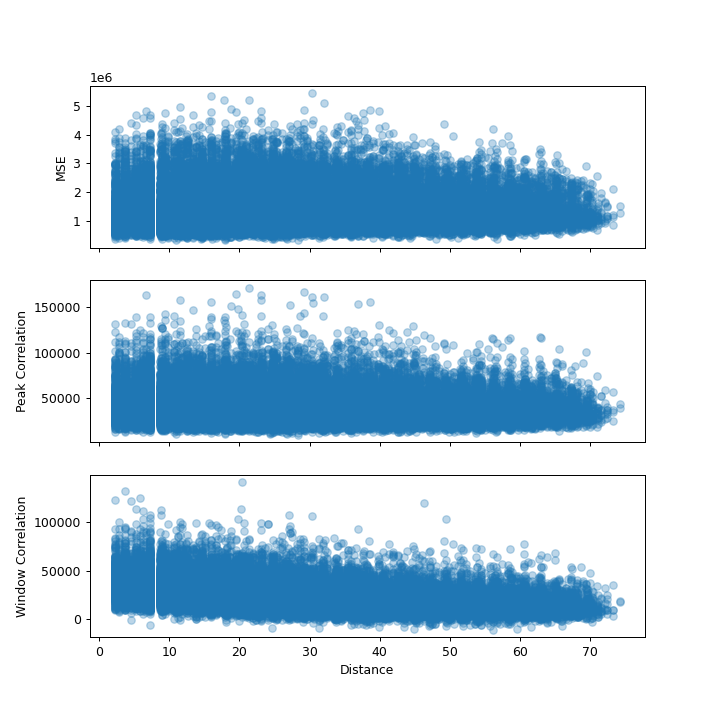

Text(0.5, 0, 'Distance')

In [13]:
dists_fig, dists_ax = plt.subplots(3, sharex=True, figsize=(8, 8))

dists_ax[0].scatter(dists, mses, alpha=0.3)
dists_ax[0].set_ylabel("MSE")

dists_ax[1].scatter(dists, peak_corrs, alpha=0.3)
dists_ax[1].set_ylabel("Peak Correlation")

dists_ax[2].scatter(dists, win_corrs, alpha=0.3)
dists_ax[2].set_ylabel("Window Correlation")

dists_ax[-1].set_xlabel("Distance")
# dists_fig.show()

### MSE of Reference ROI against all other ROIs
Scroll on figure to cycle between reference ROIs (marked by value of `0.` and red **x**)

<IPython.core.display.Javascript object>


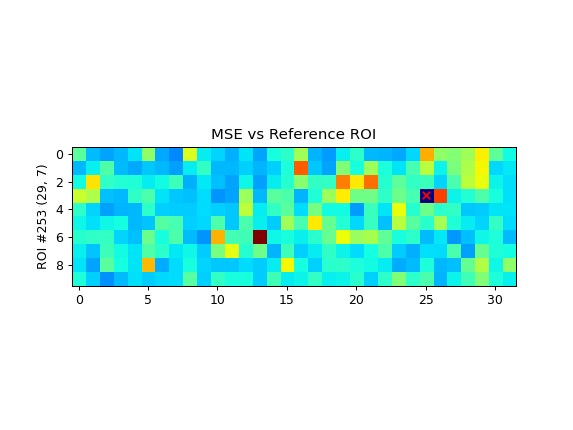

Text(0.5, 1.0, 'MSE vs Reference ROI')

In [45]:
mse_grid_stack = np.stack(
    [
#         np.array([m for _, m in sorted(ms.items())]).reshape(grid_rows, grid_cols)
        np.array([m for _, m in sorted(ms.items())]).reshape(grid_cols, grid_rows).T
        for i, ms in mse_dict.items()
    ],
    axis=0,
)

mse_grid_fig, mse_grid_ax = plt.subplots(1)
mse_grid_plot = StackPlotter(
    mse_grid_fig,
    mse_grid_ax,
    mse_grid_stack,
    delta=1,
    cmap="jet",
    z_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i % grid_cols, i // grid_cols),
)

mse_mark = mse_grid_plot.ax.scatter([0], [0], marker="x", c="red")
mse_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: mse_mark.set_offsets(
#         [[mse_grid_plot.idx % grid_cols, mse_grid_plot.idx // grid_cols]]
        [[mse_grid_plot.idx // grid_rows, mse_grid_plot.idx % grid_rows]]
    )
)

mse_grid_ax.set_title("MSE vs Reference ROI")
# mse_grid_fig.show()

In [34]:
corr_grid_stack = np.stack(
    [
        np.stack(
            [c for _, c in sorted(cs.items())], axis=0
#         ).reshape(1, grid_rows, grid_cols, -1).transpose(0, 3, 1, 2)
        ).reshape(1, grid_cols, grid_rows, -1).transpose(0, 3, 2, 1)
        for i, cs in corr_dict.items()
    ],
    axis=0,
)

### Cross-correlation of Reference ROI against all other ROIs
- Select reference ROI with slider (marked by value of `1.` and red **x**).
- Scroll on figure to cycle between over time (temporal offset of sliding correlation).

<IPython.core.display.Javascript object>


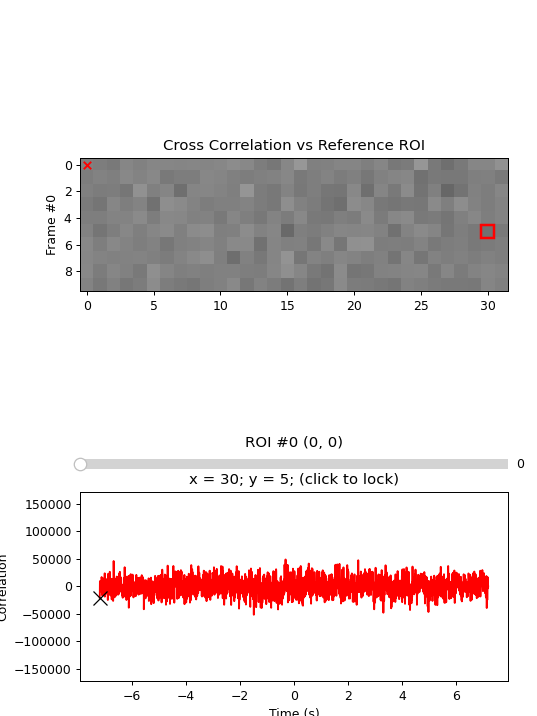

Text(0.5, 1.0, 'Cross Correlation vs Reference ROI')

In [44]:
xaxis = np.arange(recs.shape[1]) * (1 / hz)
corr_plot = StackExplorer(
    corr_grid_stack,
#     zaxis=(recs_xaxis - (recs_xaxis.max() / 2)),
    zaxis=(xaxis - (xaxis.max() / 2)),
    delta=10,
    roi_sz=1,
#     vmin=0,
#     auto_roi_scale=True,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i % grid_cols, i // grid_cols),
    figsize=(6, 8)
)
corr_plot.ax[2].set_xlabel("Time (s)")
corr_plot.ax[2].set_ylabel("Correlation")

corr_mark = corr_plot.ax[0].scatter([0], [0], marker="x", c="red")
corr_plot.n_slider.on_changed(
#     lambda v: corr_mark.set_offsets([[v % grid_cols, v // grid_cols]]))
    lambda v: corr_mark.set_offsets([[v // grid_rows, v % grid_rows]]))

corr_plot.ax[0].set_title("Cross Correlation vs Reference ROI")
# corr_plot.fig.canvas.capture_scroll = True
# corr_plot.fig.show()

### Peak cross-correlation of Reference ROI against all other ROIs
Scroll on figure to cycle between reference ROIs (marked by value of `1.` and red **x**)

<IPython.core.display.Javascript object>


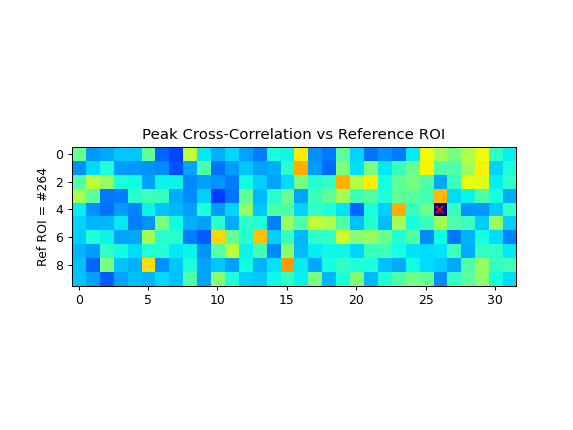

Text(0.5, 1.0, 'Peak Cross-Correlation vs Reference ROI')

In [43]:
peak_corr_grid_stack = np.stack(
    [
#         np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_cols, grid_rows).T
        for i, ps in peak_corr_dict.items()
    ],
    axis=0,
)

peak_corr_grid_fig, peak_corr_grid_ax = plt.subplots(1)
peak_corr_grid_plot = StackPlotter(
    peak_corr_grid_fig,
    peak_corr_grid_ax,
    peak_corr_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)

peak_corr_mark = peak_corr_grid_plot.ax.scatter([0], [0], marker="x", c="red")
peak_corr_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: peak_corr_mark.set_offsets(
#         [[peak_corr_grid_plot.idx % grid_cols, peak_corr_grid_plot.idx // grid_cols]]
        [[peak_corr_grid_plot.idx // grid_rows, peak_corr_grid_plot.idx % grid_rows]]
    )
)

peak_corr_grid_ax.set_title("Peak Cross-Correlation vs Reference ROI")
# peak_corr_grid_fig.show()

### Peak cross-correlation within time window of Reference ROI against all other ROIs
Scroll on figure to cycle between reference ROIs (marked by value of `1.` and red **x**)

<IPython.core.display.Javascript object>


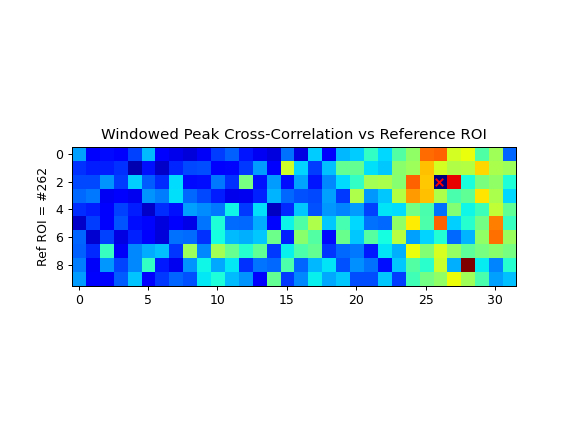

Text(0.5, 1.0, 'Windowed Peak Cross-Correlation vs Reference ROI')

In [46]:
win_peak_corr_grid_stack = np.stack(
    [
#         np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_cols, grid_rows).T
        for i, ps in win_peak_corr_dict.items()
    ],
    axis=0,
)

win_peak_corr_grid_fig, win_peak_corr_grid_ax = plt.subplots(1)
win_peak_corr_grid_plot = StackPlotter(
    win_peak_corr_grid_fig,
    win_peak_corr_grid_ax,
    win_peak_corr_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)

win_peak_corr_mark = win_peak_corr_grid_plot.ax.scatter([0], [0], marker="x", c="red")
win_peak_corr_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: win_peak_corr_mark.set_offsets(
#         [[win_peak_corr_grid_plot.idx % grid_cols, win_peak_corr_grid_plot.idx // grid_cols]]
        [[win_peak_corr_grid_plot.idx // grid_rows, win_peak_corr_grid_plot.idx % grid_rows]]
    )
)

win_peak_corr_grid_ax.set_title("Windowed Peak Cross-Correlation vs Reference ROI")
# win_peak_corr_grid_fig.show()

### Window sum of cross-correlation of Reference ROI against all other ROIs
Scroll on figure to cycle between reference ROIs (marked by value of `1.` and red **x**)

<IPython.core.display.Javascript object>


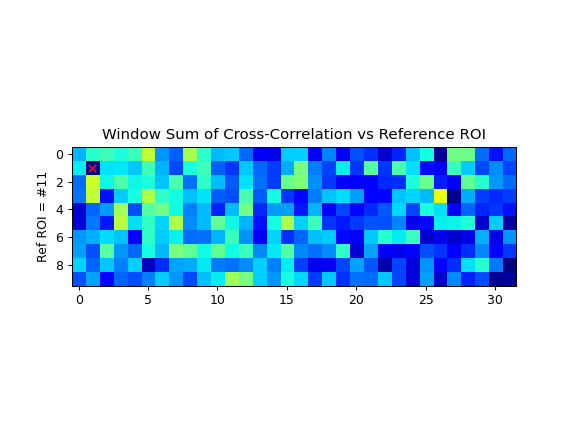

In [41]:
win_corr_grid_stack = np.stack(
    [
#         np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_cols, grid_rows).T
        for i, ps in win_corr_dict.items()
    ],
    axis=0,
)

win_corr_grid_fig, win_corr_grid_ax = plt.subplots(1)
win_corr_grid_plot = StackPlotter(
    win_corr_grid_fig,
    win_corr_grid_ax,
    win_corr_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)


win_corr_mark = win_corr_grid_plot.ax.scatter([0], [0], marker="x", c="red")
win_corr_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: win_corr_mark.set_offsets(
#         [[win_corr_grid_plot.idx % grid_cols, win_corr_grid_plot.idx // grid_cols]]
        [[win_corr_grid_plot.idx // grid_rows, win_corr_grid_plot.idx % grid_rows]]
    )
)

win_corr_grid_ax.set_title("Window Sum of Cross-Correlation vs Reference ROI")

win_corr_grid_fig.canvas.capture_scroll = True
# win_corr_grid_fig.show()

## TODO:
- better peak exploration with PeakExplorer
    - add a button that turns auto y scaling on and off
    - provide an option that allows setting the prominence using a standard deviation multiple dynamic threshold (requires index range to calculate sdev over)
- masking ROI signals with windows around detected peaks
    - idea is to only consider correlations during periods where both ROIs had events
    - is it fine to just zero out the intervening regions?
        - this would make those stretches "fully correlated" with eachother, which I suppose could contain some information, though that would be better extracted by comparing event distances between ROIs (they did something like this in Santhosh's paper)
    - perhaps replacing the non-event regions with gaussian noise with the same variance as the rest of the ROI would be better

In [29]:
# recs = grid_recs[0][:, 5000:]
recs = grid_svgl[0][:, 5000:]
# recs = grid_butt[0][:, 5000:]
recs = signal.detrend(recs)
recs = np.stack([r - r.mean() for r in recs], axis=0)
n_pts = recs.shape[-1] 

# prominence = 40
prominence = 110
peak_width = 10
peak_tolerance = .6
min_peak_interval = 1
min_peak_count = 5

lead_time = 0.5
post_time = 0.5
lead_pts = int(lead_time * hz) 
post_pts = int(post_time * hz) 
trig_pts = lead_pts + post_pts
mid_trig_idx = trig_pts // 2
blank = np.zeros(lead_pts + post_pts)

area_win_pre_dur = 0.
area_win_post_dur = 0.1
area_win_pre_pts = int(area_win_pre_dur * hz)
area_win_post_pts = int(area_win_post_dur * hz)

avg_trig_event_dict = {i: {i: None} for i in range(recs.shape[0])}
trig_area_dict = {i: {i: 0.} for i in range(recs.shape[0])}

for i in range(recs.shape[0]):
    peak_idxs, peak_proms = find_peaks(
#         recs[i],
        grid_conv[0][i, 5000:],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
    for j in range(recs.shape[0]):
        if len(peak_idxs[0]) >= min_peak_count:
            events = [
                recs[j][p-lead_pts:p+post_pts]
                for p in peak_idxs[0] if p > lead_pts and p < n_pts - post_pts
            ]
            avg_trig_event_dict[i][j] = np.mean(events, axis=0) if len(events) > 0 else blank
        else:
            avg_trig_event_dict[i][j] = blank
        
        trig_area_dict[i][j] = np.sum(
            avg_trig_event_dict[i][j][
                mid_trig_idx - area_win_pre_pts:mid_trig_idx + area_win_post_pts])

event_grid_stack = np.stack(
    [
        np.stack(
            [e for _, e in sorted(es.items())], axis=0
#         ).reshape(1, grid_rows, grid_cols, -1).transpose(0, 3, 1, 2)
        ).reshape(1, grid_cols, grid_rows, -1).transpose(0, 3, 2, 1)
        for i, es in avg_trig_event_dict.items()
    ],
    axis=0,
)

<IPython.core.display.Javascript object>


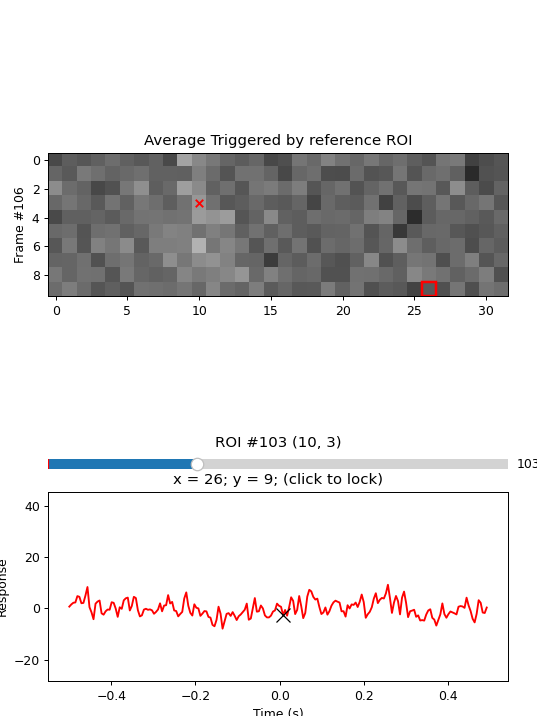

Text(0.5, 1.0, 'Average Triggered by reference ROI')

In [39]:
# interesting ROIs: 94, 99, 220, 306, 314

event_xaxis = np.arange(lead_pts + post_pts) * (1 / hz)
trig_plot = StackExplorer(
#     event_grid_stack,
    event_grid_stack - event_grid_stack.mean(axis=2, keepdims=True),
#     zaxis=(recs_xaxis - (recs_xaxis.max() / 2)),
#     zaxis=(xaxis - (xaxis.max() / 2)),
    zaxis=(event_xaxis - lead_time),
    delta=2,
    roi_sz=1,
#     vmin=0,
#     auto_roi_scale=True,
    auto_roi_scale=False,
    z_fmt_fun=(lambda i: "Frame #%i" % i),
#     n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i % grid_cols, i // grid_cols),
    n_fmt_fun=lambda i: "ROI #%i (%i, %i)" % (i, i // grid_rows, i % grid_rows), 
    figsize=(6, 8)
)
trig_plot.ax[2].set_xlabel("Time (s)")
trig_plot.ax[2].set_ylabel("Response")
trig_mark = trig_plot.ax[0].scatter([0], [0], marker="x", c="red")
trig_plot.n_slider.on_changed(
#     lambda v: trig_mark.set_offsets([[v % grid_cols, v // grid_cols]]))
    lambda v: trig_mark.set_offsets([[v // grid_rows, v % grid_rows]]))

trig_plot.ax[0].set_title("Average Triggered by reference ROI")

<IPython.core.display.Javascript object>


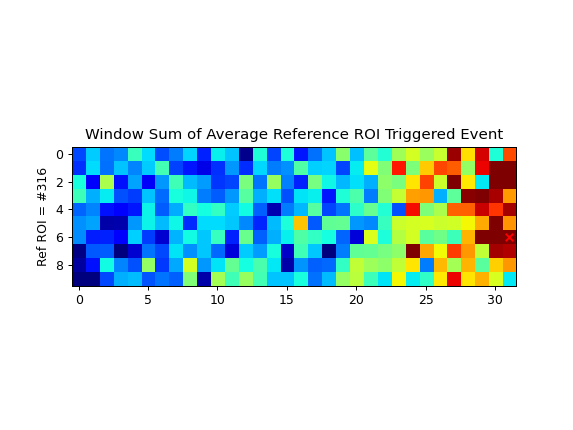

In [40]:
trig_area_grid_stack = np.stack(
    [
#         np.array([p for _, p in sorted(ps.items())]).reshape(grid_rows, grid_cols)
        np.array([p for _, p in sorted(ps.items())]).reshape(grid_cols, grid_rows).T
        for i, ps in trig_area_dict.items()
    ],
    axis=0,
)

trig_area_grid_fig, trig_area_grid_ax = plt.subplots(1)
trig_area_grid_plot = StackPlotter(
    trig_area_grid_fig,
    trig_area_grid_ax,
    trig_area_grid_stack,
    delta=1,
    z_fmt_fun=(lambda i: "Ref ROI = #%i" % i),
    cmap="jet"
)


trig_area_mark = trig_area_grid_plot.ax.scatter([0], [0], marker="x", c="red")
trig_area_grid_plot.fig.canvas.mpl_connect(
    "scroll_event",
    lambda e: trig_area_mark.set_offsets(
#         [[trig_area_grid_plot.idx % grid_cols, trig_area_grid_plot.idx // grid_cols]]
        [[trig_area_grid_plot.idx // grid_rows, trig_area_grid_plot.idx % grid_rows]]
    )
)

trig_area_grid_ax.set_title("Window Sum of Average Reference ROI Triggered Event")

trig_area_grid_fig.canvas.capture_scroll = True